<a href="https://colab.research.google.com/github/les1smore/Stat-Notes/blob/main/Modeling_CLV_with_Lifetimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agenda
1. Look at the requisite table format that our dataset needs to have prior to modeling.
2. See how train and assess a BG-NBD model using *lifetimes*.
3. Understand the various insights and analyses that *lifetimes* facilitates.
4. Discuss several practical business applications made possible by *lifetimes*.


# Data Preparation

An example transactions table is provided by lifetimes. This table records the transactions of CDNow, a dot-com era company that sold CDs and music products. It contains 6,919 transactions from 2,357 customers from 1 January 1997 to 30 June 1998 (a total of 78 weeks). 

In [15]:
pip install lifetimes

In [16]:
import pandas as pd
from lifetimes.datasets import load_dataset

transactions = load_dataset(
    filename = 'CDNOW_sample.txt',
    header = None,
    delim_whitespace = True,
    names = ['customer_id', 'customer_index','date','quantity','amount'],
    converters = {'date':lambda x: pd.to_datetime(x, format='%Y%m%d')}
)

transactions.head(3)

,customer_id,customer_index,date,quantity,amount
0,4,1,1997-01-01,2,29.33
1,4,1,1997-01-18,2,29.73
2,4,1,1997-08-02,1,14.96


Before fitting the BG-NBD model, we need to first restructure this table to the canonical "RFM" format. A format in the RFM (Recency, Frequency, Monetary) format has rows that represent individual customers and the following columns:
- *frequency*: represents the number of repeat purchases the customer hsa made
- *recency*: represents the "age" of the customer when they made their most recent purchases
- *T*: represents the "age" of the customer at the end of the observation period
- *monetary_value*: an optional column which represents the average value of a given customer's purchases excluding the first purchase
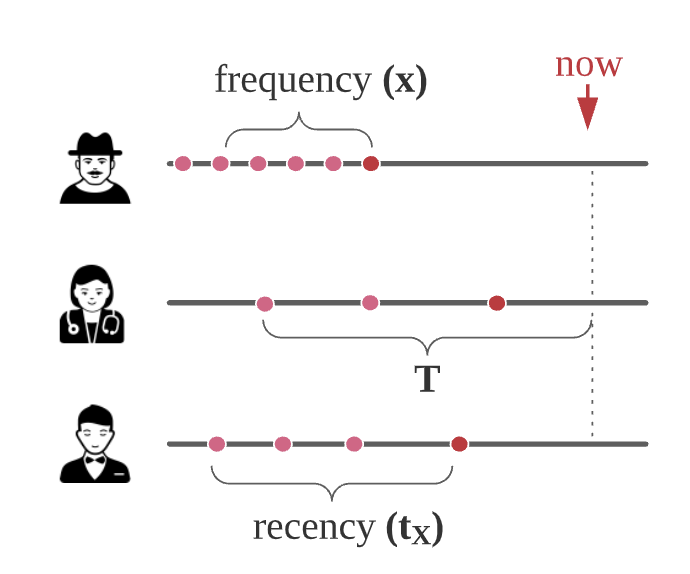

In [17]:
# lifetimes provides a utility function that facilitates the conversion from the 'transactions' format to the RFM format
from lifetimes.utils import summary_data_from_transaction_data

rfm = summary_data_from_transaction_data(transactions=transactions,
                                         customer_id_col = 'customer_id',
                                         datetime_col = 'date',
                                         monetary_value_col = 'amount',
                                         observation_period_end = pd.to_datetime('1998-06-30'),
                                         freq = 'W')
rfm.head(3)

,frequency,recency,T,monetary_value
customer_id,,,,
4,3.0,49.0,78.0,23.723333
18,0.0,0.0,78.0,0.000000
21,1.0,2.0,78.0,11.770000


Interpreting the first row of the RFM dataframe is as follows:
- During the observation period, customer 4 made a total of 4 purchases (thus 3 repeat purchases).
- The time span between her first and last purchases was 49 weeks. 
- The time span between her first purchase and the end of the observation period was 78 weeks. 
- The average of his transactions, excluding his first one, is USD 23.73.

Note that when a **zero value** for the *frequency, recency* and *monetary_value* columns (such as for customer 18) indicates that the customer **only made one purchase** in the observation period.

# Calibration-holdout split
When reformating our table into the RFM format, we have the option to also perform a calibration-holdout split, which is similar in spirit to the train-test split procedure. The calibration-holdout split divides our transactions into two depending on whether they fall into the calibration period or the observation period.

- The transactions that took place during the *calibration period* are used to *train* the model.
- The transcations that occurred during the *observation period* ('holdout' transactions) are used to *validate* the model.
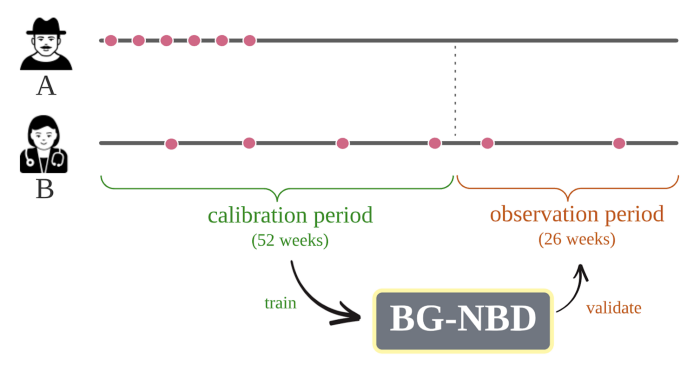

In this example, we'll set the calibration and the observation periods to be 52 and 26 weeks, respectively.

In [18]:
from lifetimes.utils import calibration_and_holdout_data

rfm_cal_holdout = calibration_and_holdout_data(transactions = transactions,
                                               customer_id_col = 'customer_id',
                                               datetime_col = 'date',
                                               monetary_value_col = 'amount',
                                               freq = 'W',
                                               calibration_period_end = '1998-01-01',
                                               observation_period_end = '1998-06-30')
rfm_cal_holdout.head(3)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
4,3.0,49.0,52.0,23.723333,0.0,0.0,26.0
18,0.0,0.0,52.0,0.000000,0.0,0.0,26.0
21,1.0,2.0,52.0,11.770000,0.0,0.0,26.0


Now each customer is associated with both calibration features for model training and holdout (observation period) features for model validation.

# Training, Prediction and Evaluation

## Fitting
In *lifetimes*, the model fitting follows the familiar scikit-learn steps of instantiating a model object (which optionally includes hyperparameter setup) and fitting it to the calibration (training) data.

In [19]:
from lifetimes import BetaGeoFitter

# instantiation of BG-NBD model
bgf = BetaGeoFitter(penalizer_coef = 0.0)

# fitting of BG-NBD model
bgf.fit(frequency = rfm_cal_holdout['frequency_cal'],
        recency = rfm_cal_holdout['recency_cal'],
        T = rfm_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.53, alpha: 6.73, b: 1.97, r: 0.28>

A BG-NBD model is composed of a Gamma and a Beta distribution. The parameters r and α of the Gamma distribution and a and b of the Beta distribution are accessible through the *.summary* attribute of the fitted model object.

In [20]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.281847,0.014034,0.254340,0.309354
alpha,6.732810,0.532304,5.689494,7.776126
a,0.532360,0.122632,0.292000,0.772719
b,1.971260,0.575322,0.843628,3.098892


## Assessment of model fit

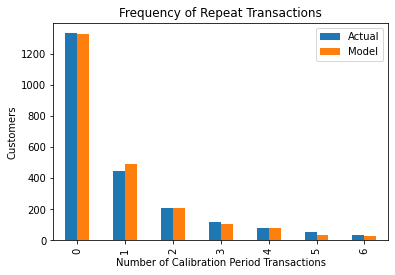

In [21]:
# First is to compare the frequencies between our real calibration data and artificial data sampled from the distributions generated by the BG-NBD model
from lifetimes.plotting import plot_period_transactions

_ = plot_period_transactions(bgf)

The plot shows that the distribution of frequencies in the training data largely agrees with that ariticially generated by our fitted model. This suggests that the physical process that we assume to have generated our data is captured pretty well by our model!

## Prediction

When given a customer with specific frequency, recency and T, a fitted model object can generate two types of predictions:
1. The number of purchases he'll make in k future periods
2. The probability of him being active at the end of the observation period

In [22]:
# First we choose a sample customer
sample_customer = rfm_cal_holdout.iloc[20]

# Inspect this customer's frequency, recency and T both for the calibration and observation periods
sample_customer

frequency_cal              3.000000
recency_cal               28.000000
T_cal                     52.000000
monetary_value_cal        25.076667
frequency_holdout          2.000000
monetary_value_holdout    29.480000
duration_holdout          26.000000
Name: 226, dtype: float64

According to the result above, the customer made 2 + 1 = 3 transactions (the "+ 1" comes from converting the number of repeat transactions, which exclude the first transaction, to toal transactions).

In [23]:
# Calculate the conditional expected number of transactions in the given period
n_transactions_pred = bgf.predict(t = 26, # set it to 26 weeks (the length of the observation period)
                                  frequency = sample_customer['frequency_cal'],
                                  recency = sample_customer['recency_cal'],
                                  T = sample_customer['T_cal'])
n_transactions_pred

0.7647440846242359

We see that the predicted transaction number (0.76 transactions) is lower than the actual one (3 transactions).

Now we can similarly predict the probability that a certain customer is still active/alive at the end of the calibration period/start of the observation period.

In [24]:
alive_prob = bgf.conditional_probability_alive(frequency = sample_customer['frequency_cal'],
                                               recency = sample_customer['recency_cal'],
                                               T = sample_customer['T_cal'])
alive_prob

array([0.57089896])

Since the customer did make some purchases in the observation period, we know with absolute certainty that he was active at the end of the calibration period. As such, the predicted probability of 0.57 is an underestimate.

## Compare the real and predicted number of transactions
Having seen how to make number-of-transactions prediction for one individual, we can extend the procedure to our whole customer base. The resulting predictions can then be compared with the real transaction data to gauge the accuracy of our model.

In [25]:
# Get the real number of transactions in the observation period, which equals frequency_holdout + 1
rfm_cal_holdout['n_transactions_holdout_real'] = rfm_cal_holdout['frequency_holdout'] + 1

# Get the predicted number of transactions in the next 26 weeks (lenght of the observation period)
rfm_cal_holdout['n_transactions_holdout_pred'] = bgf.predict(t=26,
                                                             frequency=rfm_cal_holdout['frequency_cal'],
                                                             recency = rfm_cal_holdout['recency_cal'],
                                                             T = rfm_cal_holdout['T_cal'])
# Compare the real and predicted transactions
rfm_cal_holdout[['n_transactions_holdout_real', 'n_transactions_holdout_pred']].head()

,n_transactions_holdout_real,n_transactions_holdout_pred
customer_id,,
4,1.0,1.155554
18,1.0,0.118167
21,1.0,0.128974
50,1.0,0.118167
60,1.0,0.126350


With a more rigorous assessment, these two columns can be subjected to typical regression metrics such as RMSE.

In [26]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_true = rfm_cal_holdout['n_transactions_holdout_real'],
                          y_pred = rfm_cal_holdout['n_transactions_holdout_pred'],
                          squared = False)
RMSE

1.3536793286521

# Insights and Interpretation

Once we are satisfied with the performance of our model, we can proceed to derive insights from it.

A good starting point would be the extraction and visualization of the estimated Gamma and Beta parameters. The Gamma and Beta distributions carry out important business significance.

The Gamma distribution tells us about the distribution of the transaction rates of our customer base, while the Beta distribution reflects the distribution of probability-to-deactivate.



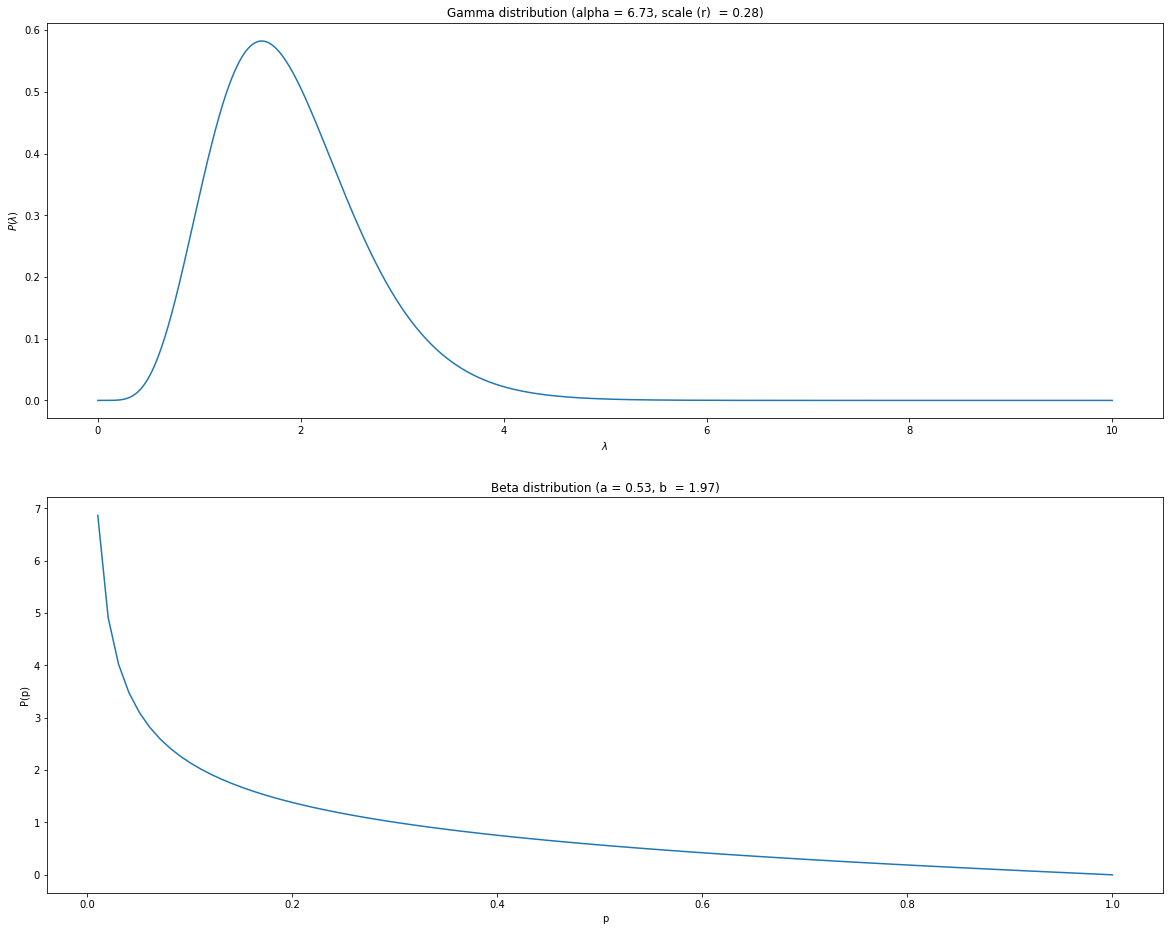

In [28]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

fig, (ax_gamma, ax_beta) = plt.subplots(ncols=1, nrows=2, figsize=(20,16))

x_gamma = np.linspace(0, 10, 1000)
y_gamma = stats.gamma.pdf(x_gamma, a = bgf.params_['alpha'], scale = bgf.params_['r'])
ax_gamma.plot(x_gamma, y_gamma,'-')
ax_gamma.set_title(f'Gamma distribution (alpha = {bgf.params_["alpha"]:.2f}, scale (r)  = {bgf.params_["r"]:.2f})')
ax_gamma.set_xlabel(r'$\lambda$')
ax_gamma.set_ylabel(r'$P(\lambda)$')

x_beta = np.linspace(0, 1, 100)
y_beta = stats.beta.pdf(x_beta, a=bgf.params_["a"], b=bgf.params_["b"])
ax_beta.plot(x_beta, y_beta, "-")
ax_beta.set_title(f'Beta distribution (a = {bgf.params_["a"]:.2f}, b  = {bgf.params_["b"]:.2f})')
ax_beta.set_xlabel('p')
ax_beta.set_ylabel('P(p)')
plt.show()

From the plot, we can see that the Gamma distribution is relatively healthy, with most of the λ found near 2. This means our customers are expected to shop at a rate of 2 transactions per week.

The Beta distribution also seems healthy, with most of the p found near 0. This implied that our customers are unlikely to deactivate soon.


## Frequency/Recency/Future Purchases Matrix

In addition to the model-fit assessment described, the fitted model object can also be used for some interpretative analysis.

For example, we can look at its Frequency/Recency/Future Purchases Matrix. This matrix shows how different frequency-recency combinations give rise to different expected numbers of future purchases.

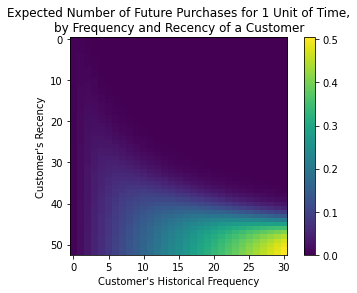

In [30]:
from lifetimes.plotting import plot_frequency_recency_matrix

_ = plot_frequency_recency_matrix(bgf)

As we can see, out best customers are in the bottom right corner, they made frequent purchases pretty recently, so we have a high expectation that they'll come back.

On the contrary, our least promising customers are in the top right corner, they made frequent purchases and then stopped coming and we haven't seen them in months. It is likely that they've found another store (i.e. they've deactivated).

## Frequency/Recency/Probability Alive Matrix

Similarly, we can also produce the Frequency/Recency/Probability Alive Matrix. This matrix shares the same axes as the previous one, but now the shade of each cell tells us the alive probability of customers with various frequency-recency combinations.


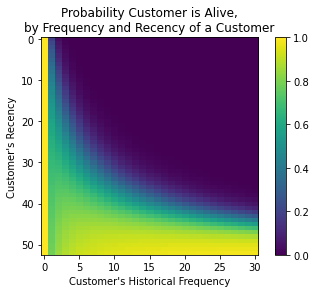

In [32]:
from lifetimes.plotting import plot_probability_alive_matrix

_ = plot_probability_alive_matrix(bgf)

Unsurprisingly, we can see similar patterns, in which the best and the worst customers are in the top right and the bottom right of the matrix, respectively.

# CLV estimation using BG-NBD

We can use the BG-NBD model to predict the probability-of-being-alive p as well as number of purchases in the next k periods. These two predictions can in turn be used to calculate a rought estimate of the customer's value for the next k periods. The estimate can be calculated as follows:


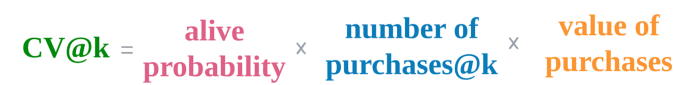

This estimate relies on the following two simplistic assumptions:
1. The probability-of-being-alive p remains unchanged in the next k periods
2. The average value of purchases in the next k periods equals the average purchase values in the observation period.

In [33]:
# The predicted number of transactions in the next 10 weeks
rfm_cal_holdout['n_transactions_10_pred'] = bgf.predict(t=10,
                                                        frequency=rfm_cal_holdout['frequency_holdout'],
                                                        recency=rfm_cal_holdout['recency_cal'],
                                                        T=rfm_cal_holdout['T_cal'])

# The probability of being alive
rfm_cal_holdout['alive_prob'] = bgf.conditional_probability_alive(frequency = rfm_cal_holdout['frequency_cal'],
                                                                  recency = rfm_cal_holdout['recency_cal'],
                                                                  T = rfm_cal_holdout['T_cal'])

# Multiply the alive probability and number of purchases and average past purchase
rfm_cal_holdout['value_10_pred'] = rfm_cal_holdout['alive_prob'] * \
                                  rfm_cal_holdout['n_transactions_10_pred'] *\
                                rfm_cal_holdout['monetary_value_cal']

rfm_cal_holdout[["value_10_pred", "alive_prob", "n_transactions_10_pred", "monetary_value_cal"]].head()


,value_10_pred,alive_prob,n_transactions_10_pred,monetary_value_cal
customer_id,,,,
4,0.960479,0.862647,0.046933,23.723333
18,0.000000,1.000000,0.046933,0.000000
21,0.134470,0.243428,0.046933,11.770000
50,0.000000,1.000000,0.046933,0.000000
60,0.000000,1.000000,0.050285,0.000000


The resulting value_10_pred column encapsulates the estimated value of our customers for the next 10 weeks. We can then use this estimate to measure the health of our business. For example, we can obtain summary statistics of value_10_pred:

In [34]:
rfm_cal_holdout['value_10_pred'].describe()

count    2357.000000
mean        2.175315
std         7.783899
min         0.000000
25%         0.000000
50%         0.000000
75%         0.916748
max       131.024991
Name: value_10_pred, dtype: float64

We see that on average, we’d expect customers to spend around $5.18 in the next 10 weeks.


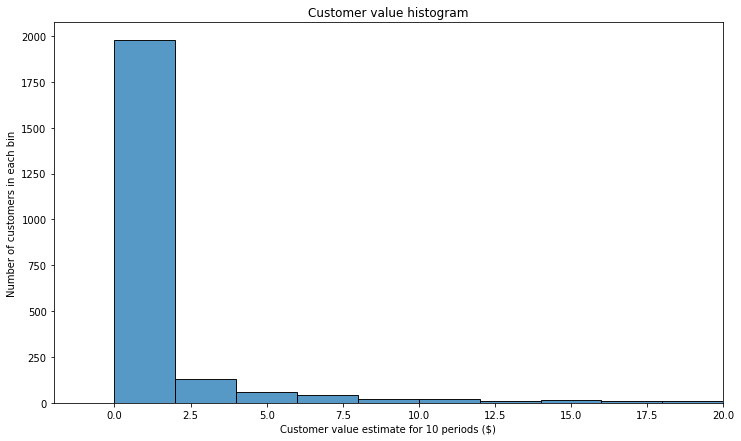

In [35]:
# Plot a histogram
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.histplot(rfm_cal_holdout['value_10_pred'],
                  kde=False,
                  binwidth=2)
ax.set_title(f'Customer value histogram')
ax.set_xlabel(r'Customer value estimate for 10 periods ($)')
ax.set_ylabel(r'Number of customers in each bin')
ax.set_xlim(-2,20)

plt.show()

We see that a big chunk of our customers have value_10_pred close to 0. The resulting average of $5.18 was driven by a few outliers (a handful of customers with a very high value_10_pred).

## Proactive intervention
- These three new columns, alive_prob, n_transactions_10_pred and value_10_pred, crystalize and quantify aspects of our customers that were previously invisible. Apart from being informational, these new features can be used to drive concrete actions. 

- For example, we can use these new features to selectively and proactively reach out to different segments of our customers with the goal of increasing their expected CLV.

- We've previouslt concluded that our overall customer value is largely attributable to a few high value customers. As these customers are our revenue drivers, we'd want to pay special attention to them. One idea is to occasionally send them congratulatory messages/vouchers to encourage their continuous loyalty.

In [36]:
VALUE_10_PRED_THRESHOLD = 10

# Filter for high-value customers
rfm_cal_holdout.loc[rfm_cal_holdout['value_10_pred'] > VALUE_10_PRED_THRESHOLD, ['value_10_pred']]

,value_10_pred
customer_id,
111,70.586712
166,11.499270
564,32.334747
619,43.064952
1099,15.559224
...,...
22754,72.896460
22937,40.914658
22975,22.313734


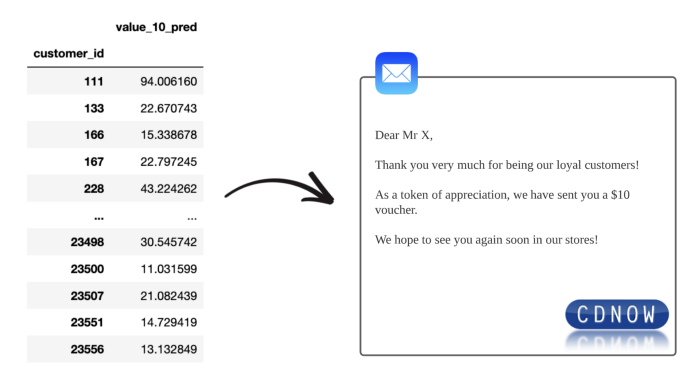

Another idea is to contact customers with high probability of churning (i.e. those with low probability of being alive) to discourage them from abandoning our business.

## Demand prediction
As we've seen before, value_10_pred estimates the amount of purchases that our customers will make in the next ten periods. 

**Another way to make use of this is to regard this value as predicted demand from the customer.** This prediction can in turn support our supply chain decision (e.g. stock replenishing or manufacturing schedule). 

Words of caveat: the BG-NBD was not conceived as a time-series model; it is not equipped with time-series features such as the accounting of seasonality and trend. As such, when it comes to forecasting, it would be prudent to not only rely on the forecasts made by BG-NBD and rather combine it with time series models such as **ARIMA**.
